In [22]:
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

import lightgbm as lgb
from sklearn.base import BaseEstimator
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from utilsforecast.losses import rmse, mae, mape, smape
from utilsforecast.evaluation import evaluate

pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize = (10, 8))
plt.rc("font", size = 10)

# data

In [2]:
def load_data():
    # data path
    data_url = "https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/PJM_Load_hourly.csv"
    # data read
    df = pd.read_csv(data_url, parse_dates = ["Datetime"])
    # data rename
    df.columns = ["ds", "y"]
    # add unique_id col
    df.insert(0, "unique_id", "PJM_Load_hourly")
    # ds transform
    df["ds"] = pd.to_datetime(df["ds"])
    # sort
    df = df.sort_values(["unique_id", "ds"]).reset_index(drop = True)
    
    return df

         unique_id                  ds        y
0  PJM_Load_hourly 1998-04-01 01:00:00  22259.0
1  PJM_Load_hourly 1998-04-01 02:00:00  21244.0
2  PJM_Load_hourly 1998-04-01 03:00:00  20651.0
3  PJM_Load_hourly 1998-04-01 04:00:00  20421.0
4  PJM_Load_hourly 1998-04-01 05:00:00  20713.0

             unique_id                  ds        y
32891  PJM_Load_hourly 2001-12-31 20:00:00  36392.0
32892  PJM_Load_hourly 2001-12-31 21:00:00  35082.0
32893  PJM_Load_hourly 2001-12-31 22:00:00  33890.0
32894  PJM_Load_hourly 2001-12-31 23:00:00  32590.0
32895  PJM_Load_hourly 2002-01-01 00:00:00  31569.0

(32896, 3)


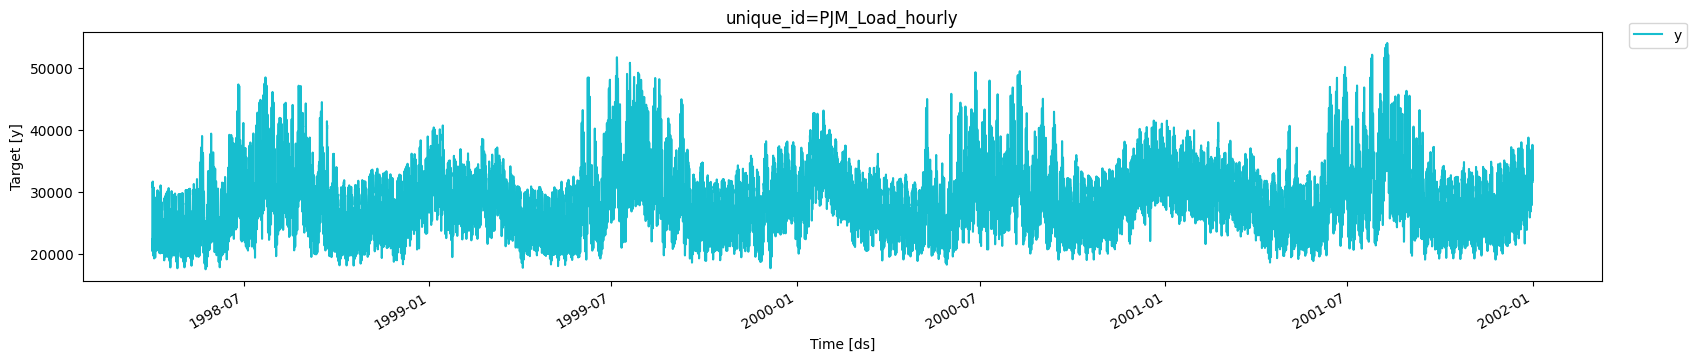

In [16]:
df = load_data()
print(df.head())
print()
print(df.tail())
print()
print(df.shape)
fig = plot_series(df)
fig

# data split

In [4]:
threshold_time = df["ds"].max() - pd.Timedelta(hours = 24)

# train dataset
df_train = df.loc[df["ds"] <= threshold_time, :]
# test dataset
df_last_24_hours = df.loc[df["ds"] > threshold_time, :]
print(df_train.shape)
print(df_last_24_hours.shape)

(32872, 3)
(24, 3)


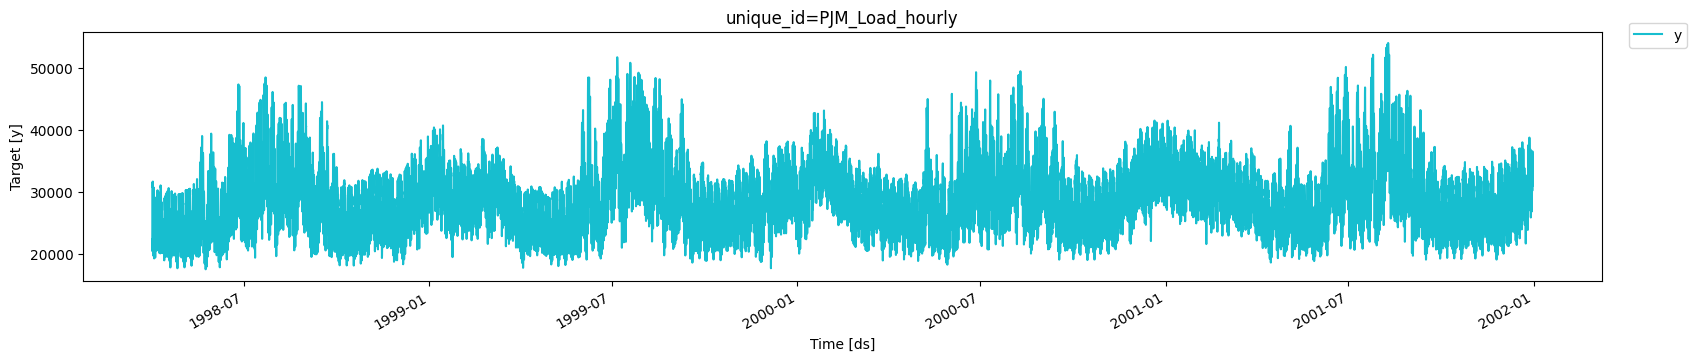

In [5]:
fig1 = plot_series(df_train)
fig1

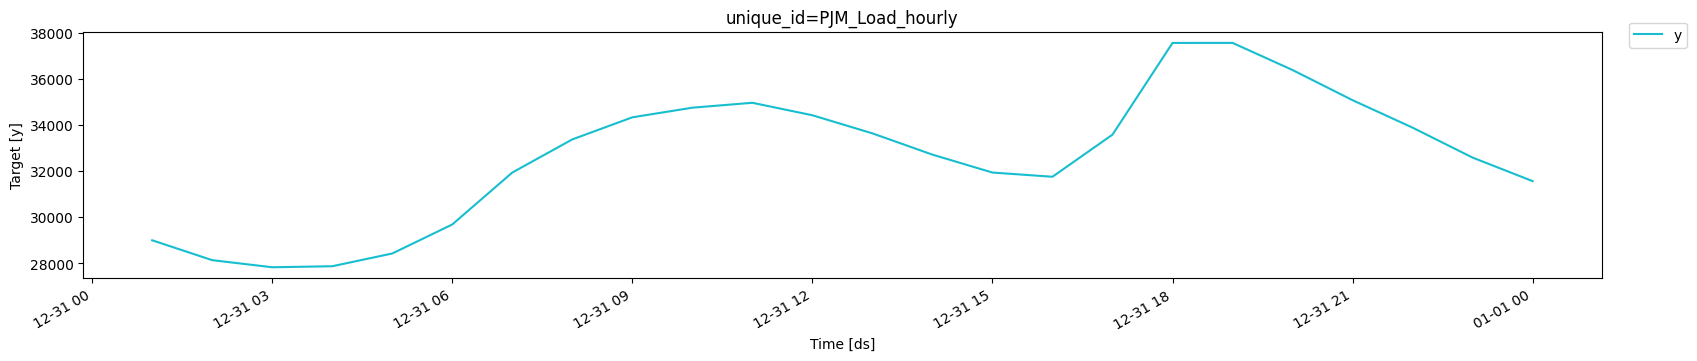

In [6]:
fig2 = plot_series(df_last_24_hours)
fig2

# 分析季节性

In [7]:
def plot_differences(df, differences: List[int], fname):
    prep = [df]
    
    # Plot individual Differences
    for d in differences:
        fcst = MLForecast(
            models = [],
            freq = 'H',
            target_transforms = [Differences([d])],
        )
        df_ = fcst.preprocess(df)
        df_['unique_id'] = df_['unique_id'] + f'_{d}'
        prep.append(df_)
    
    # Plot combined Differences
    fcst = MLForecast(
        models = [],
        freq = 'H',
        target_transforms = [Differences([24, 24 * 7])],
    )
    df_ = fcst.preprocess(df)
    df_['unique_id'] = df_['unique_id'] + f'_all_diff'
    prep.append(df_)
    
    prep = pd.concat(prep, ignore_index=True)
    
    # return prep
    n_series = len(prep['unique_id'].unique())
    fig, ax = plt.subplots(nrows = n_series, figsize = (7 * n_series, 10 * n_series), squeeze = False)
    for title, axi in zip(prep['unique_id'].unique(), ax.flat):
        df_ = prep[prep['unique_id'] == title]
        df_.set_index('ds')['y'].plot(title = title, ax = axi)
    # fig.savefig(f'../../figs/{fname}', bbox_inches='tight')
    plt.show()
    plt.close()

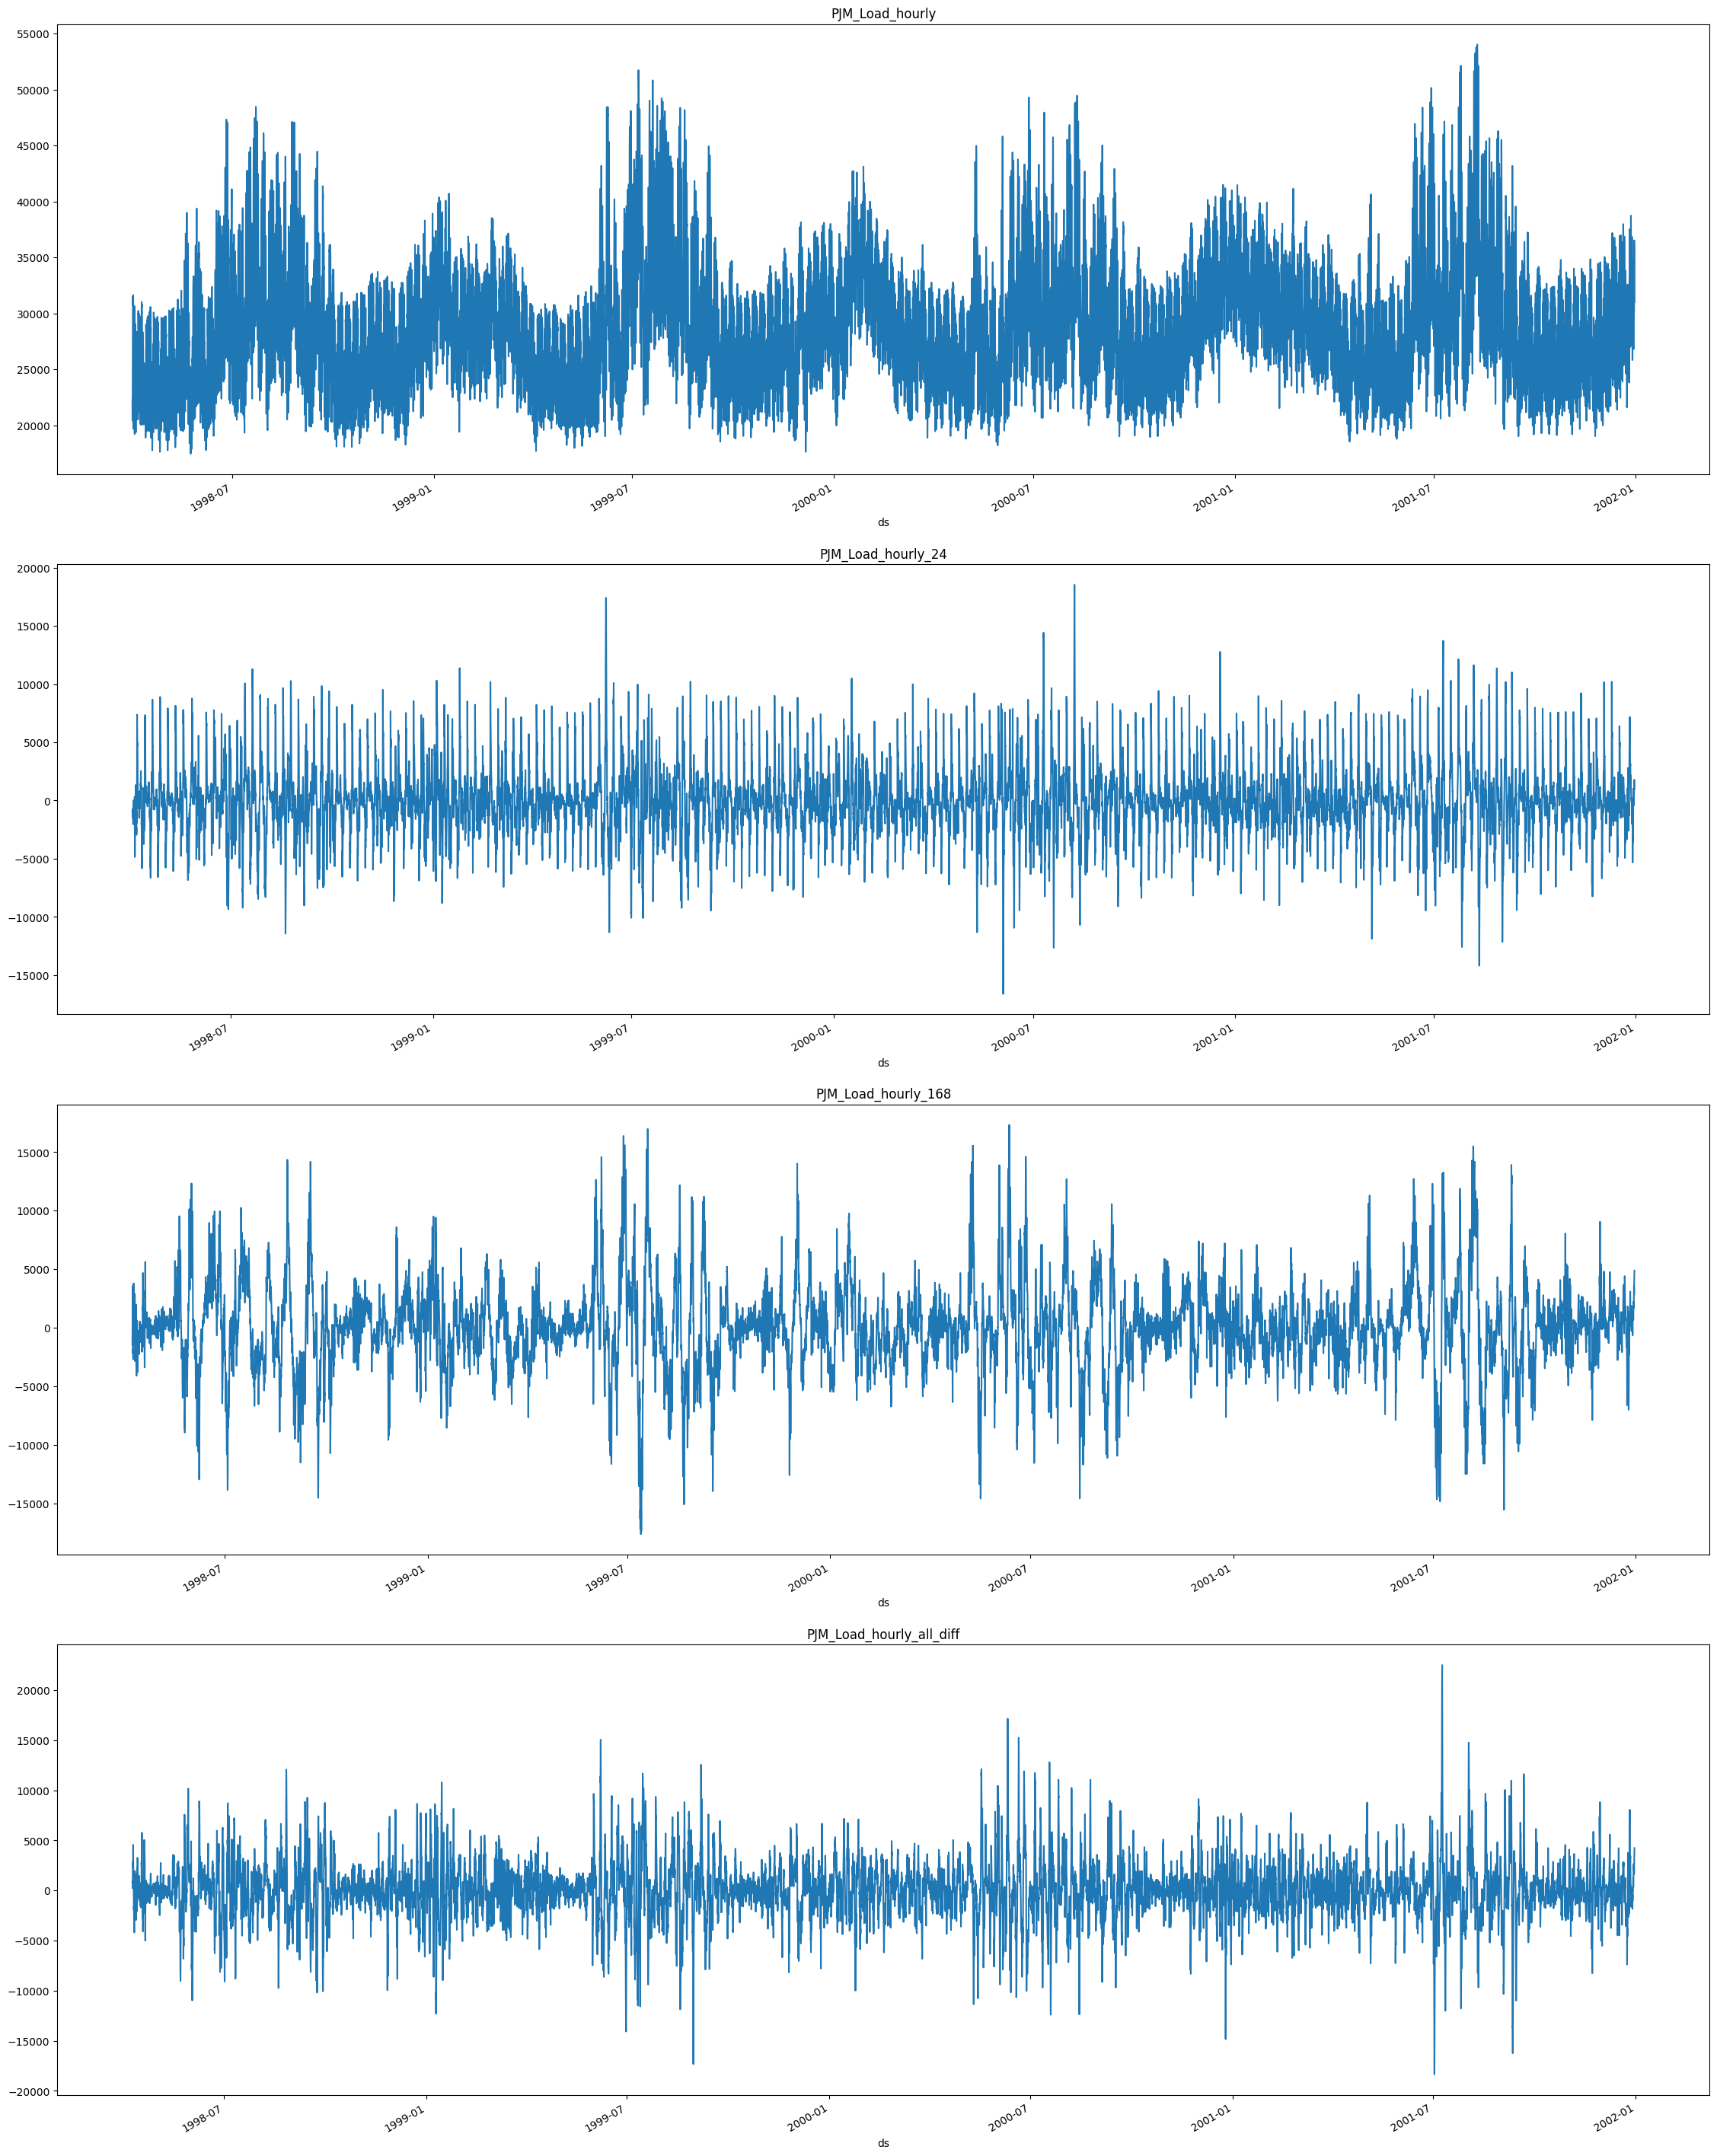

In [8]:
plot_differences(df=df_train, differences=[24, 24*7], fname = 'load_forecasting__differences.png')

# 通过交叉验证进行模型选择

## Baseline

In [10]:
# navie model
from sklearn.base import BaseEstimator

class Naive(BaseEstimator):
    
    def fit(self, X, y):
        return self

    def predict(self, X):
        return X['lag1']

## 模型

In [13]:
# Model dictionary
models ={
    'naive': Naive(),
    'lgbm': lgb.LGBMRegressor(verbosity = -1),
    'lasso': Lasso(),
    'lin_reg': LinearRegression(),
    'ridge': Ridge(),
    'knn': KNeighborsRegressor(),
    'mlp': MLPRegressor(), 
    'rf': RandomForestRegressor(),
}

In [14]:
mlf = MLForecast(
    models = models, 
    freq = 'H',
    target_transforms = [Differences([24, 24*7])],
    lags=[1, 12, 24],
    lag_transforms={  
        1: [ExpandingMean()],
        24: [RollingMean(window_size = 48)],
    },
    date_features = ['month', 'hour', 'dayofweek'],
)

In [19]:
crossvalidation_df = mlf.cross_validation(
    df = df_train,
    h = 24,
    n_windows = 4,
    refit = False,
)

In [20]:
print(crossvalidation_df.head())
print(crossvalidation_df.shape)

         unique_id                  ds     cutoff        y    naive  \
0  PJM_Load_hourly 2001-12-27 01:00:00 2001-12-27  28332.0  28837.0   
1  PJM_Load_hourly 2001-12-27 02:00:00 2001-12-27  27329.0  27969.0   
2  PJM_Load_hourly 2001-12-27 03:00:00 2001-12-27  26986.0  27435.0   
3  PJM_Load_hourly 2001-12-27 04:00:00 2001-12-27  27009.0  27401.0   
4  PJM_Load_hourly 2001-12-27 05:00:00 2001-12-27  27555.0  28169.0   

           lgbm         lasso       lin_reg         ridge      knn  \
0  28526.505572  28703.185712  28702.625949  28702.625956  28479.0   
1  27467.860847  27693.502318  27692.395954  27692.395969  27521.6   
2  26605.710615  26991.795124  26990.157567  26990.157589  26451.6   
3  26284.065138  26789.418399  26787.262262  26787.262291  26388.4   
4  26823.617078  27369.643789  27366.983075  27366.983111  26779.6   

            mlp        rf  
0  28619.640435  28257.17  
1  27517.060584  27342.06  
2  26741.567636  26579.97  
3  26472.863562  26340.54  
4  27020.981

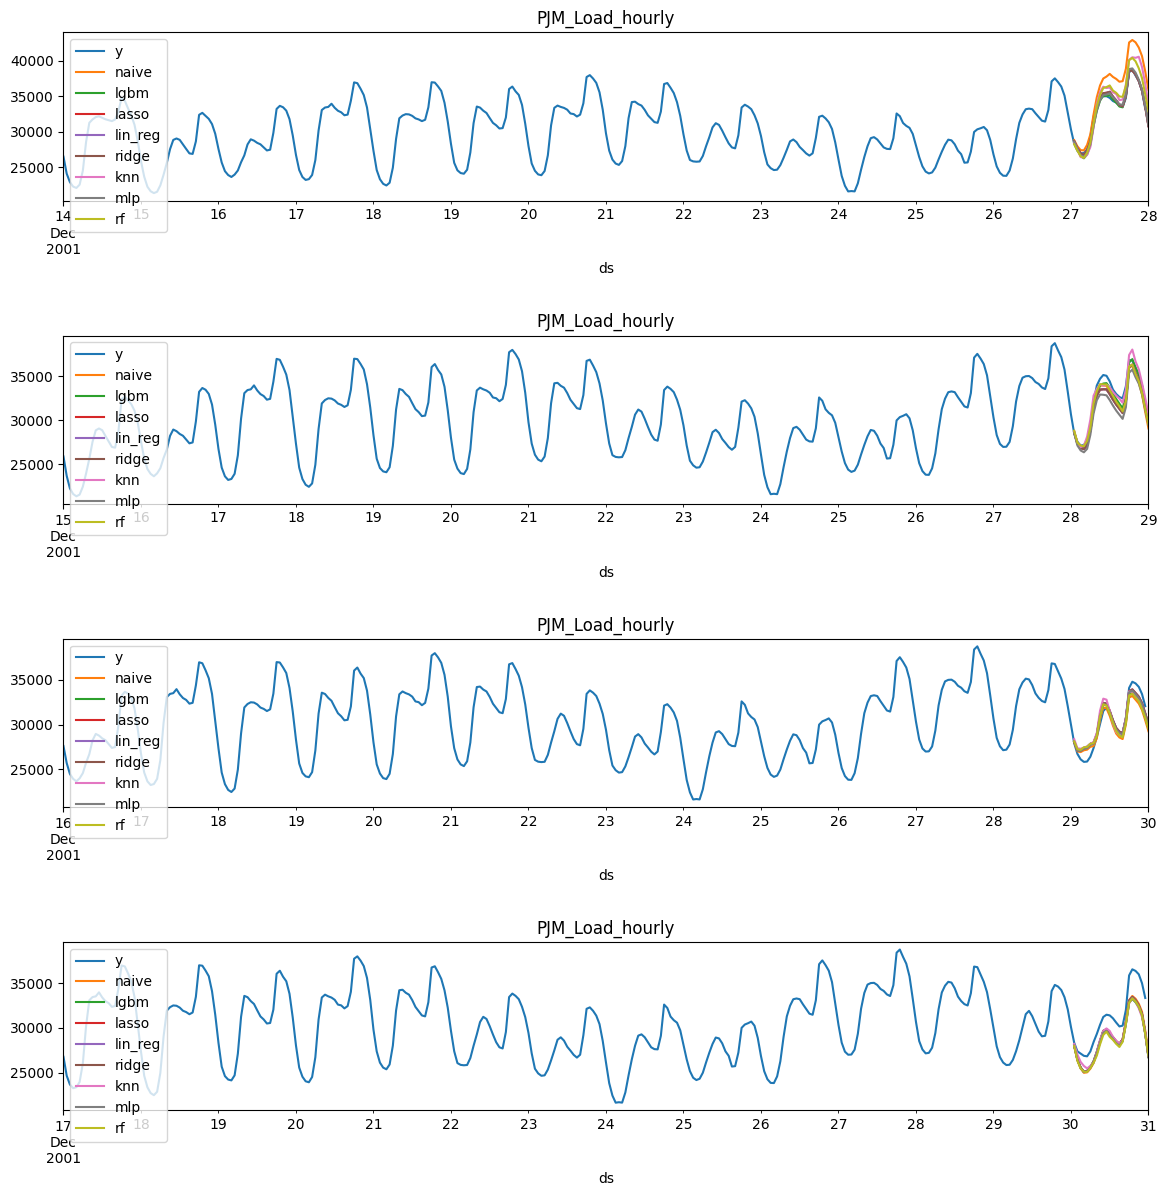

In [21]:
def plot_cv(df, df_cv, uid, fname, last_n = 24 * 14, models = {}):
    cutoffs = df_cv.query('unique_id == @uid')['cutoff'].unique()
    fig, ax = plt.subplots(nrows = len(cutoffs), ncols = 1, figsize = (14, 14), gridspec_kw = dict(hspace=0.8))
    for cutoff, axi in zip(cutoffs, ax.flat):
        max_date = df_cv.query('unique_id == @uid & cutoff == @cutoff')['ds'].max()
        df[df['ds'] < max_date].query('unique_id == @uid').tail(last_n).set_index('ds').plot(ax = axi, title = uid, y = 'y')
        for m in models.keys():
            df_cv.query('unique_id == @uid & cutoff == @cutoff').set_index('ds').plot(ax = axi, title = uid, y = m)          
    # fig.savefig(f'../../figs/{fname}', bbox_inches='tight')
    plt.show()
    plt.close()

plot_cv(df_train, crossvalidation_df, 'PJM_Load_hourly', 'load_forecasting__predictions.png', models=models)

## 模型评估

In [23]:
# Metrics to be used for evaluation
metrics = [
    mae,
    rmse,
    mape,
    smape
]

In [24]:
# Function to evaluate the crossvalidation
def evaluate_crossvalidation(crossvalidation_df, metrics, models):
    evaluations = []
    for c in crossvalidation_df['cutoff'].unique():
        df_cv = crossvalidation_df.query('cutoff == @c')
        evaluation = evaluate(
            df = df_cv,
            metrics=metrics,
            models=list(models.keys())
            )
        evaluations.append(evaluation)
    evaluations = pd.concat(evaluations, ignore_index=True).drop(columns='unique_id')
    evaluations = evaluations.groupby('metric').mean()
    
    return evaluations.style.background_gradient(cmap='RdYlGn_r', axis=1)

evaluate_crossvalidation(crossvalidation_df, metrics, models)

,naive,lgbm,lasso,lin_reg,ridge,knn,mlp,rf
metric,,,,,,,,
mae,1631.395833,971.536200,1003.796433,1007.998597,1007.998547,1248.145833,1182.729807,1263.811146
mape,0.049759,0.030966,0.031760,0.031888,0.031888,0.038721,0.037180,0.039390
rmse,1871.398919,1129.713256,1148.616156,1153.262719,1153.262664,1451.964390,1329.346279,1420.577147
smape,0.024786,0.015886,0.016269,0.016338,0.016338,0.019549,0.019106,0.020054
